In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor, BernoulliRBM
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge,RANSACRegressor,Lasso
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, RocCurveDisplay, mean_squared_error, mean_squared_log_error, roc_curve, PrecisionRecallDisplay, r2_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, RadiusNeighborsClassifier, RadiusNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, GradientBoostingClassifier, GradientBoostingRegressor

c:\Users\cdnec\MarketPulse\.venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
docs = pd.read_parquet('../data/sts_gb.parquet').set_index('date').squeeze()#['statement']

In [8]:
y = pd.read_parquet('../data/prices_min.parquet')
y=y.asfreq('D').bfill().loc[docs.index]
y = y.dropna(axis=1)

In [4]:
model_name = 'philschmid/bge-base-financial-matryoshka'
# model_name = 'FinLang/finance-embeddings-investopedia'

In [5]:
encoder = SentenceTransformer(model_name)

In [6]:
X = encoder.encode(docs.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, shuffle=False)

In [10]:
def multioutput_scorer(scorer, y_true, y_pred, **kwargs):
    def f(series, scorer, **kwargs):
        score = scorer(series['y_true'], series['y_pred'])
        try:
            ci = score.confidence_interval()
        except AttributeError:
            return {'Score':score}
        else:
            result = {'Score':score[0]}
            result.update(zip(['low', 'high'],ci))
            # print(result)
            return pd.Series(result)
    y_pred = pd.DataFrame(y_pred, index=y_true.index, columns=y_true.columns)
    df = pd.concat([y_true, y_pred], keys=['y_true', 'y_pred'])
    results = df.apply(f, scorer=scorer, result_type='expand', **kwargs)
    return results.T

In [11]:
reg=LinearRegression()
model = make_pipeline(
    PCA(
            16,
            # whiten=True
        ),
    reg
)

In [12]:
model.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=16)),
                ('linearregression', LinearRegression())])

In [13]:
p_train = model.predict(X_train)
p_val = model.predict(X_val)

In [14]:
def get_optimal_threshold(y, p):
    fpr, tpr, thresholds = roc_curve(y>0, p, drop_intermediate=True)
    opt_idx = np.argmax(tpr-fpr)
    # print(opt_idx)
    return thresholds[opt_idx]

In [15]:
thresholds = [get_optimal_threshold(y, p) for y, p in zip(y_train.values.T, p_train.T)]

In [16]:
y_true, y_pred = y_val, p_val

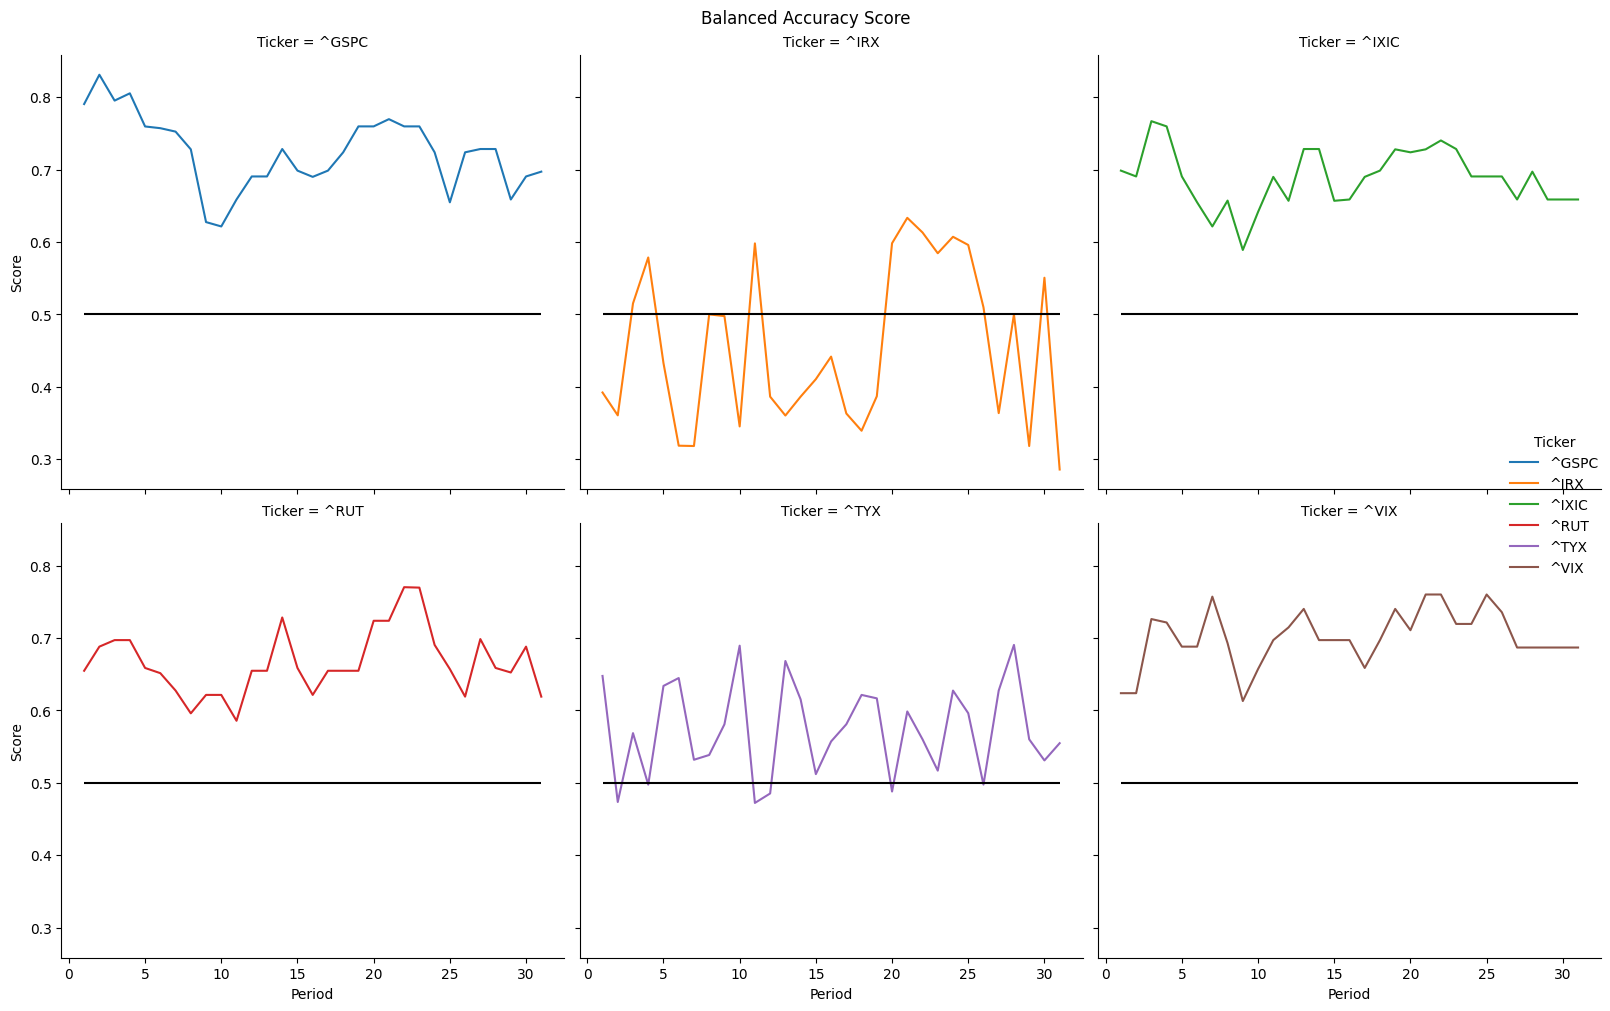

In [17]:
results = multioutput_scorer(balanced_accuracy_score, y_true>0, y_pred>thresholds)
results = results.reset_index()
grid = sns.relplot(results, y='Score', x='Period', hue='Ticker', kind='line', col='Ticker', col_wrap=3);
for ticker, grp in results.groupby('Ticker'):
    ax=grid.axes_dict[ticker]
    ax.hlines(.5, grp['Period'].min(), grp['Period'].max(), color='black')
grid.fig.suptitle('Balanced Accuracy Score');
grid.fig.set_constrained_layout(True)

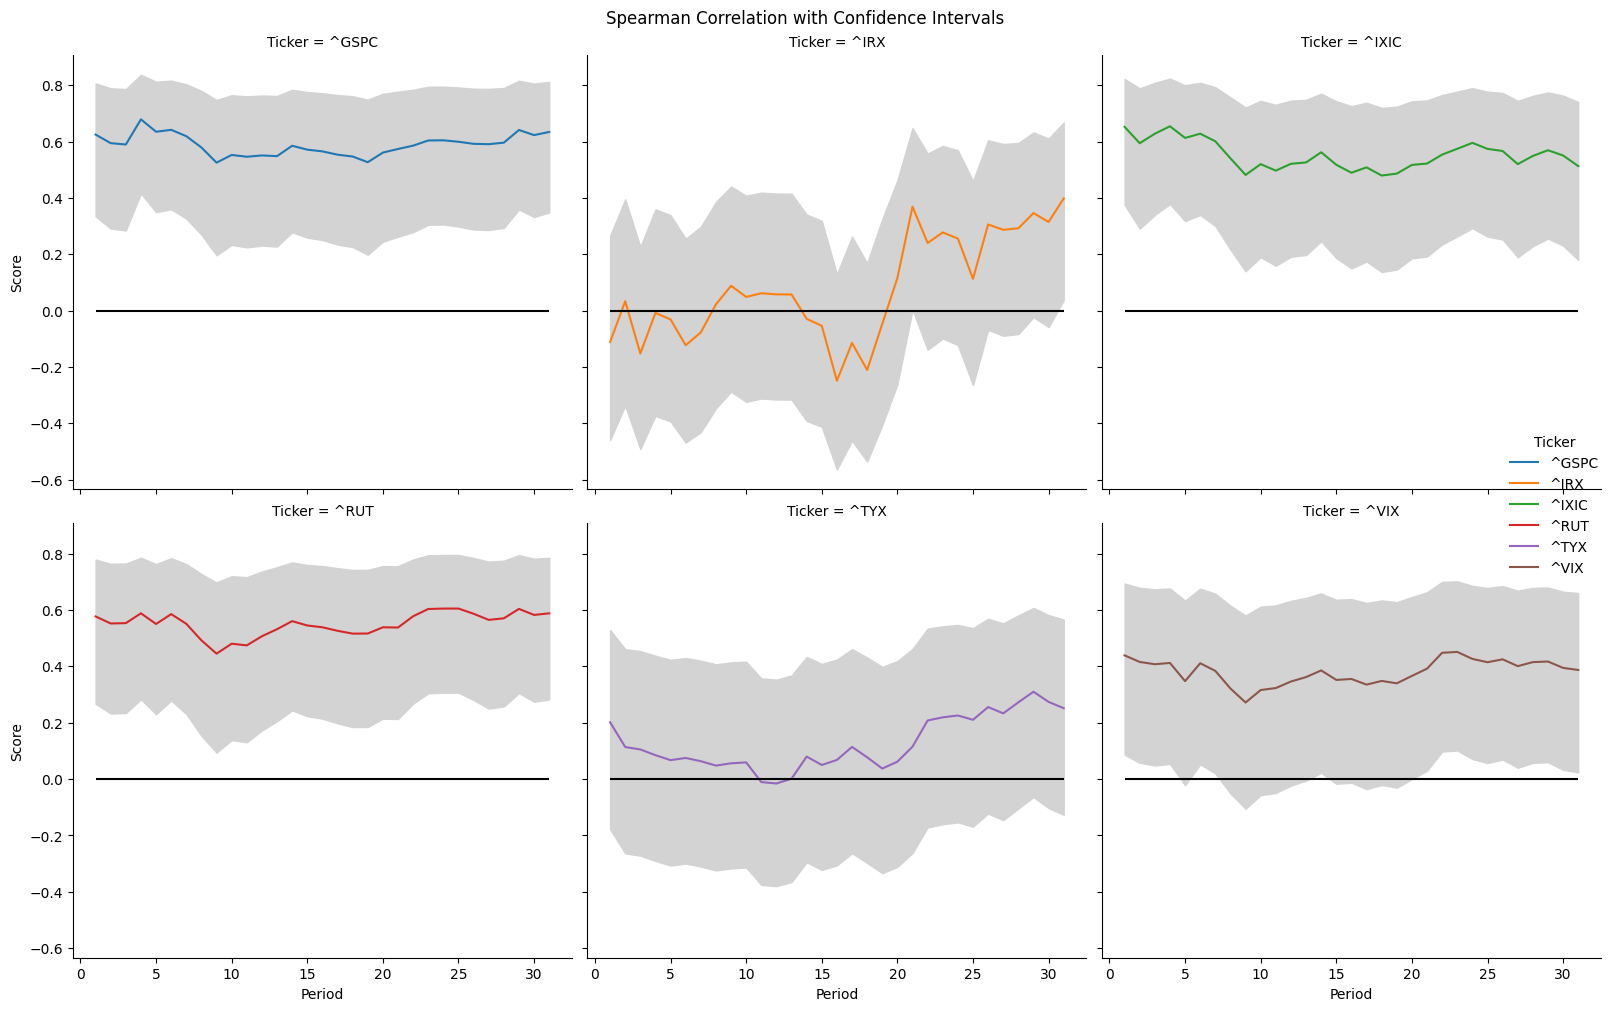

In [18]:
results = multioutput_scorer(pearsonr, y_true, y_pred)
results = results.reset_index()
grid=sns.relplot(results, y='Score', x='Period', hue='Ticker', kind='line', col='Ticker', col_wrap=3);
for ticker, grp in results.groupby('Ticker'):
    ax=grid.axes_dict[ticker]
    ax.fill_between('Period', 'low', 'high', data=grp, color='lightgrey')
    ax.hlines(0, grp['Period'].min(), grp['Period'].max(), color='black')
grid.fig.suptitle('Spearman Correlation with Confidence Intervals');
grid.fig.set_constrained_layout(True)

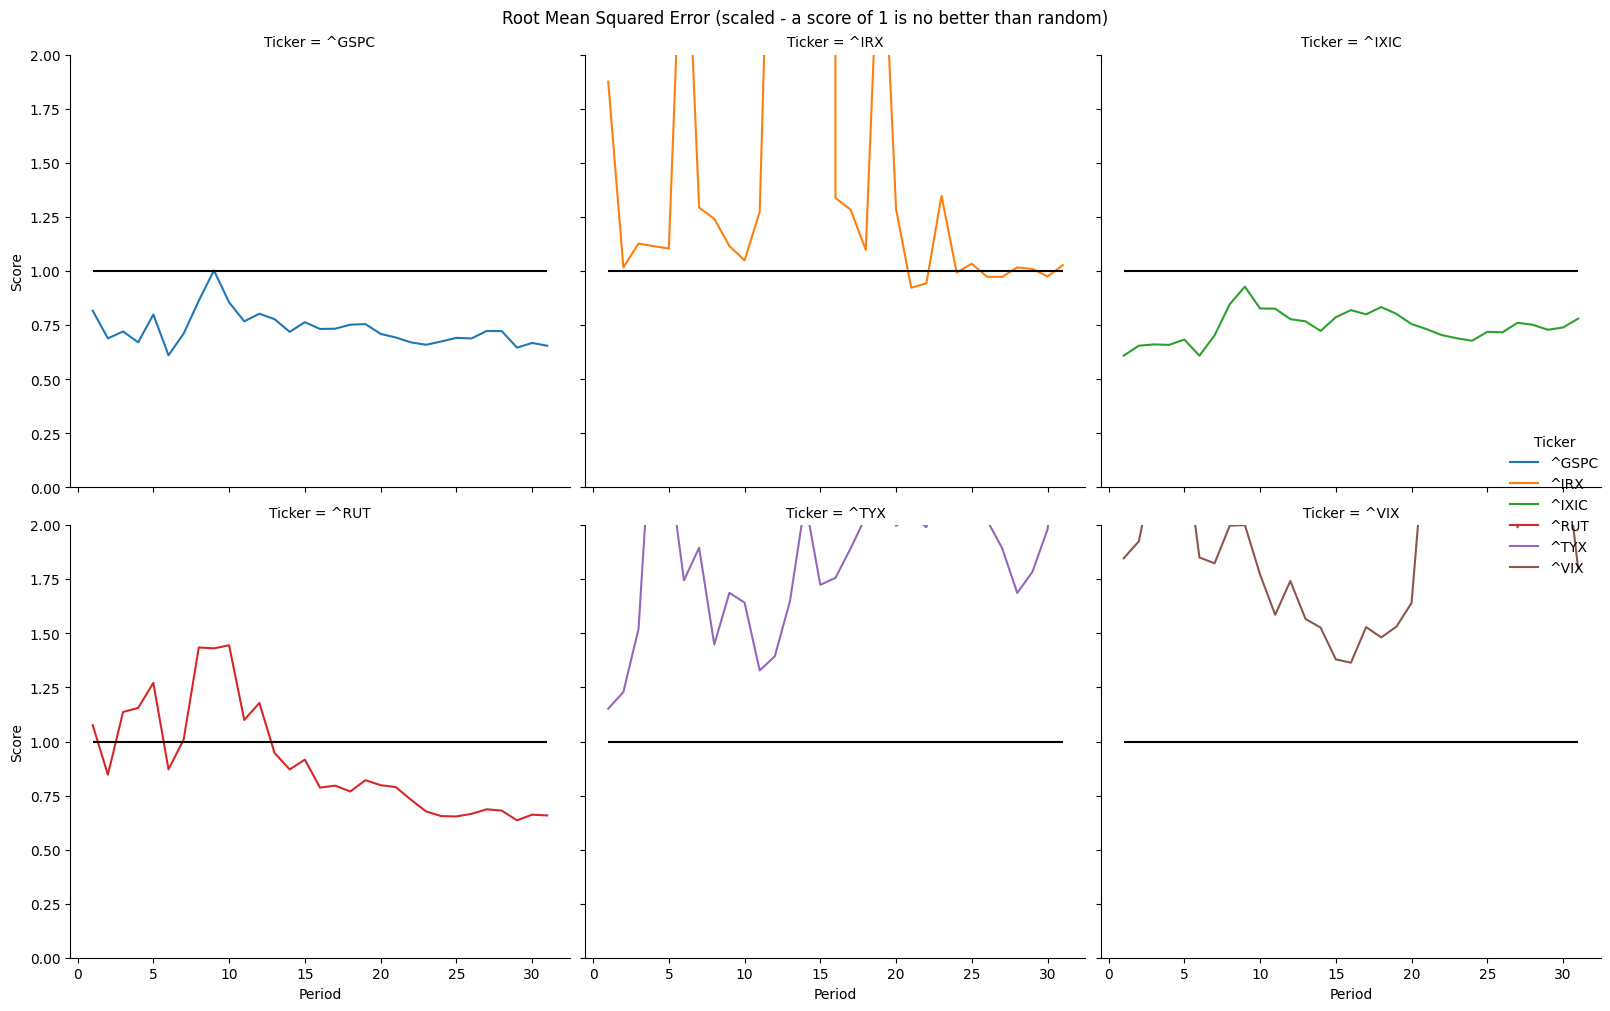

In [19]:
scaler = StandardScaler()
t = pd.DataFrame(scaler.fit_transform(y_true), y_true.index, y_true.columns)
p = pd.DataFrame(scaler.transform(y_pred), y_true.index, y_true.columns)
results = multioutput_scorer(mean_squared_error, t, p, squared=False)
results = results.reset_index()
grid = sns.relplot(results, y='Score', x='Period', hue='Ticker', kind='line', col='Ticker', col_wrap=3);
for ticker, grp in results.groupby('Ticker'):
    ax=grid.axes_dict[ticker]
    ax.set_ylim(0,2)
    ax.hlines(1, grp['Period'].min(), grp['Period'].max(), color='black')
grid.fig.suptitle('Root Mean Squared Error (scaled - a score of 1 is no better than random)');
grid.fig.set_constrained_layout(True)

In [274]:
# y_pred = DummyRegressor().fit(X_train, y_train).predict(X_val)
# scaler = StandardScaler()
# t = pd.DataFrame(scaler.fit_transform(y_true), y_true.index, y_true.columns)
# p = pd.DataFrame(scaler.transform(y_pred), y_true.index, y_true.columns)
# results = multioutput_scorer(mean_squared_error, t, p, squared=False)
# results = results.reset_index()
# grid = sns.relplot(results, y='Score', x='Period', hue='Ticker', kind='line', col='Ticker', col_wrap=3);
# for ticker, grp in results.groupby('Ticker'):
#     ax=grid.axes_dict[ticker]
# #     sl = y_true.loc[:, pd.IndexSlice[:, ticker]].values
# # # ax.hlines(.5, grp['Period'].min(), grp['Period'].max(), color='black')
# #     ax.set_ylim(0, sl.mean() + 2*sl.std())
#     ax.set_ylim(0,2)